<div class="list-group" id="list-tab" role="tablist">
<a id='0'></a>    
<h1 style="padding: 4px; color:white; display:fill; background:#456789; font-size:130%"><b> Contents </b></h1>

 - <a href='#1' style="color:#1589FF; font-size:110%"><b>1. Preliminaries</b></a>
    - <a href='#1_1' style="color:#1589FF"><b>1.1. Data Description</b></a>
    - <a href='#1_2' style="color:#1589FF"><b>1.2. Imports and Utility Functions</b></a>
<p></p>
 - <a href='#2' style="color:#1589FF; font-size:110%"><b>2. Load: no Nans / Nulls</b></a>
<p></p> 
 - <a href='#3' style="color:#1589FF; font-size:110%"><b>3. MLP Classifier Modelling</b></a>
    - <a href='#3_1' style="color:#1589FF"><b>3.1. ACF and PACF Are The Input</b></a>
    - <a href='#3_2' style="color:#1589FF"><b>3.2. Time Series Raw Data Are The Input</b></a>
<p></p> 
 - <a href='#4' style="color:#1589FF; font-size:110%"><b>4. Conclusion</b></a>

<a id='1'></a>
<p style="padding: 8px;color:#456789; display:fill;background-color:#ADD8E6; font-size:200%"> <b>1. Preliminaries</b>

<a id='1_1'></a>
<p style="color:#1589FF;text-align: center; font-size:150%"> <b>1.1. Data Description</b>

__The synthetic dataset is modeled after the following assumptions.__
1. _"The Process" follows ARMA(p,q) model:_
    - 1 <= p <= 3;
    - 1 <= q <= 3;
    - AR coefficients are > -1 and < 1;
    - MA coefficients are >= 0 and < 1;
    - the random variables in MA part are taken from a standard Levy distribution with alpha in [0.25, 1];
    - 80 time points;
    - for each set __(__ (p,q), AR coefficients, MA coefficients, alpha __)__ we generate one instance of "the Process";
    - we don't care about any other assumptions / limitations.
>
2. _Correlation Functions:_
    - maximum lag is 19;
    - for each instance of "the Process" we compute ACF and PACF.
>
3. _We don't do __any__ postprocessing of the data:_
    - both "the Process", ACF and PACF are saved "as is" - no averaging, (de)noising etc.

<a id='1_2'></a>
<p style="color:#1589FF;text-align: center; font-size:150%"> <b>1.2. Imports and Utility Functions</b>

In [11]:
import numpy as np
import math as mt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)  # tensorflow, please, stop annoying me with "INFO:tensorflow:Assets written to"

import tensorflow as tf
 
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

import pandas as pd
import json
from datetime import datetime

def LoadJ(filename):
    with open(filename, 'r') as f:
        adata = json.load(f)
    return adata

def DerivePQData(adata, dataprefix):
    x = np.array([[adata[_][0]]+[len(adata[_][1])-1]+[len(adata[_][2])-1]+adata[_][4][1:] for _ in range(len(adata))])
    c = ["idx","P","Q"]+[dataprefix+"_"+str(_) for _ in range(1,len(adata[-1][4]))]
    y = pd.DataFrame(x, columns = c).sort_values(["P","Q"], ignore_index=True)
    y = y.astype({"idx": int, "P": int, "Q": int})
    return y

def DeriveDataClass(adata):
    y = adata.copy()
    y["Class"] = pd.Series(pd.factorize(y.iloc[:,1:3].apply(tuple, axis=1))[0])
    y.drop(columns=["P","Q"], inplace=True)
    return y

def DF_Brief(df, df_descr):
    print('\033[1m'+"The brief info about: "+df_descr+'\033[0m')
    df.info()
    print('')
    print('\033[1m'+"Counts for the missing data"+'\033[0m')
    display(df.isna().sum())
    display(df.head(1))

def series_hist(ser, ax, col_name, atitle, clsss_l):
    ax.hist(ser, bins=len(clsss_l), weights=np.ones(len(ser)) * 100. / len(ser))    
    ax.set_title(atitle+f": {len(ser)}")
    ax.set(xticks=[_ for _ in range(len(clsss_l))], xticklabels=clsss_l)    

def show_datasets_structure_wrt_Classes(whole_ds,whole_Title, train_ds,train_Title, validate_ds, val_Title, test_ds,test_Title,
                                        classes_col, classes_Labels):
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(12,12))
    series_hist(whole_ds, ax0, classes_col, whole_Title, classes_Labels)
    series_hist(train_ds, ax1, classes_col, train_Title, classes_Labels)
    series_hist(validate_ds, ax2, classes_col, val_Title, classes_Labels)
    series_hist(test_ds, ax3, classes_col, test_Title, classes_Labels)
    ax0.set_ylabel("Percents")
    ax2.set_ylabel("Percents")
    ax2.set_xlabel(classes_col)
    ax3.set_xlabel(classes_col)
    fig.tight_layout()
    plt.show()

def get_nodes_per_layer(aNodes, aLayers, aNodes_out, aBase=2):
    assert isinstance(aNodes, int) and (aNodes > 0), 'Quantity of Nodes must be positive integer'
    assert isinstance(aLayers, int) and (aLayers > 0), 'Quantity of Layers must be positive integer'
    assert aBase >= 1, 'Rate of nodes per layer growth must be >= 1'
    n_p_l = np.zeros(aLayers, dtype=int)
    if aLayers == 1:
        n_p_l[0] = aNodes
    else:
        if aBase>1:
            n_p_l[-1] = max(int( aNodes / ((aBase**aLayers - 1)/(aBase-1)) ), aNodes_out)
            for i in range(2,len(n_p_l)+1):
                n_p_l[len(n_p_l)-i] = mt.ceil(aBase*n_p_l[len(n_p_l)-i+1])
        else:
            for i in range(len(n_p_l)):
                n_p_l[i] = int(aNodes/aLayers)
        n_p_l[0] = aNodes - (np.array(n_p_l).sum() - n_p_l[0])
    return n_p_l

def Model_create(aLayers, n_p_l, act_func, aNodes_in, aCntclasses):
    mdl = tf.keras.Sequential()
    mdl.add(Dense(n_p_l[0], activation=act_func, input_shape=(aNodes_in,)))
    for _ in range(1,aLayers) :
        mdl.add(Dense(n_p_l[_], activation=act_func))
    mdl.add(Dense(aCntclasses,  activation="softmax"))
    return mdl

def get_npl_str(aNpL):
    return '_'.join(str(_) for _ in aNpL)

def get_chkpt_filename_from_NpLstr(act_func, aNodes, aLayers, NpLstr, aSavePrefix):
    prfx = 'no_prefix' if aSavePrefix=="" else aSavePrefix    
    return prfx+'_'+act_func+'_Nodes_'+str(aNodes)+'_Layers_'+str(aLayers)+'_NpL_'+NpLstr

def get_chkpt_filename(act_func, aNodes, aLayers, aNpL, aSavePrefix):
    return get_chkpt_filename_from_NpLstr(act_func, aNodes, aLayers, get_npl_str(aNpL), aSavePrefix)

def check_layers_base_pair(layers, base, TotalNodes, min_out_nodes):
    if layers==1:
        r = base==1
    elif base==1:
        r = min_out_nodes*layers <= TotalNodes
    else:
        r = (base**layers - 1)/(base-1)  <= TotalNodes/min_out_nodes
    return r

def DoStudy(Input_Nodes, aCntclasses, aCntsamples, EPOCHS, BATCH_S, X_tr, y_tr, X_val, y_val, X_te, y_te, aSavePrefix='no_prefix'):
    print('\033[1m'+f"Training with {Input_Nodes} input nodes, {aCntclasses} output nodes, {EPOCHS} epochs and batch size = {BATCH_S}."+'\033[0m')
    p_list = []
#    N_nodes = set([max(mt.ceil(mt.sqrt(aCntclasses*Input_Nodes)), aCntclasses),
#                   max(mt.ceil(aCntsamples/(aCntclasses+Input_Nodes)), aCntclasses),
#                   max(int(3*aCntclasses*mt.sqrt(aCntsamples/(aCntclasses+2))), aCntclasses)])
    A = max(mt.ceil(np.log10(aCntsamples)/2),1)
    N_nodes = [50*i*aCntclasses for i in range(1,A)]
    print('\033[1m'+f"We use Numbers of Nodes: {N_nodes}."+'\033[0m')
    start_training = datetime.now()
    for activation_function in ['sigmoid','relu']:
        start_with_activation = datetime.now()
        for aNodes in N_nodes:
            LayersBases = [[l,b] for l in set([1,2,3,A]) for b in [1,1.5,2]
                           if check_layers_base_pair(l, b, aNodes, aCntclasses)]
            for lb in LayersBases:
                N_layers = lb[0]
                change_base = lb[1]
                Nodes_per_Layer = get_nodes_per_layer(aNodes, N_layers, aCntclasses, change_base)

                model = Model_create(N_layers, Nodes_per_Layer, activation_function, Input_Nodes, aCntclasses)
                #model.summary()
                model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
                chkpt_fname = CheckpointsPath + get_chkpt_filename(activation_function,aNodes,N_layers,Nodes_per_Layer, aSavePrefix)
                model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=chkpt_fname, verbose=0,
                                                                               save_weights_only=False,
                                                                               monitor='val_sparse_categorical_accuracy',
                                                                               mode='max', save_best_only=True)
                starttime = datetime.now()
                model.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH_S,
                          validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback], verbose=0)
                time_elapsed = datetime.now()-starttime

                model = tf.keras.models.load_model(chkpt_fname)
                Train_Loss, Train_Metrics = model.evaluate(X_tr, y_tr, verbose=0, batch_size=BATCH_S)
                Val_Loss, Val_Metrics = model.evaluate(X_val, y_val, verbose=0, batch_size=BATCH_S)
                Test_Loss, Test_Metrics = model.evaluate(X_te, y_te, verbose=0, batch_size=BATCH_S)
                p_list.append([activation_function,aNodes,N_layers,get_npl_str(Nodes_per_Layer),Train_Loss,Train_Metrics, Val_Loss,Val_Metrics, Test_Loss, Test_Metrics, time_elapsed])
                print("     "+f"Training with \'{activation_function}\', {aNodes} nodes, {N_layers} layers and {get_npl_str(Nodes_per_Layer)} nodes per layer completed in {str(time_elapsed)}")
        print("     "+'\033[1m'+f"Training Time with {activation_function} activation: "+'\033[0m'+"{}".format(datetime.now() - start_with_activation))
    print('\033[1m'+"Total training time: "+'\033[0m'+"{}".format(datetime.now() - start_training))
    return p_list

def results_table(perf_list):
    p_table = pd.DataFrame(perf_list,columns=['Activation','Num Nodes','Num Hidden','Hidden Struct','Train Loss','Train Metrics','Val Loss','Val Metrics','Test Loss','Test Metrics','Time Elapsed'])
    p_table.set_index(['Activation','Num Nodes','Num Hidden','Hidden Struct'], inplace=True)
    display(p_table.style.background_gradient(cmap='coolwarm',
                                      subset=['Train Loss','Train Metrics','Val Loss','Val Metrics','Test Loss','Test Metrics']\
                                     ).format({'Train Loss': '{:.4f}','Train Metrics': '{:.2%}',
                                               'Val Loss': '{:.4f}','Val Metrics': '{:.2%}',
                                               'Test Loss': '{:.4f}','Test Metrics':'{:.2%}'}))    
    return p_table

def ConfusionMatrix(perf_table, aCheckpointsPath, X_te, y_te, aClasses_List, aClasses_Labels, aSavePrefix):
    tbr = perf_table[perf_table["Val Metrics"]==perf_table["Val Metrics"].max()].copy()
    tbr.reset_index(inplace=True)
    the_best_model_save = get_chkpt_filename_from_NpLstr(tbr["Activation"][0],tbr["Num Nodes"][0],tbr["Num Hidden"][0],tbr["Hidden Struct"][0], aSavePrefix)
    model = tf.keras.models.load_model(aCheckpointsPath + the_best_model_save)
    print('\033[1m' + 'Confusion Matrix for the best model: ' + '\033[0m' + the_best_model_save)
    cm = confusion_matrix(y_te, (model.predict(X_te, verbose=0)).argmax(axis=1), labels=aClasses_List)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=aClasses_Labels)
    fig, ax = plt.subplots(figsize=(8,8))
    cmd.plot(ax=ax)

[Back to Contents](#0)

<a id='2'></a>
<p style="padding: 8px;color:#456789; display:fill;background-color:#ADD8E6; font-size:200%"> <b>2. Load: no Nans / Nulls</b>

__Set the value of the APATH to the folder with the data files__

In [12]:
APATH = os.path.expanduser('~')+'/Python Scripts/ARMA_NN/'

__Set the value of the CheckpointsPath to the folder with the NN Checkpoints files__

In [13]:
CheckpointsPath = APATH + 'NN_Checkpoints/'

In [14]:
CorrFuncs_prefix = 'CorrFuncs'
RawData_prefix   = 'TimeSeries'

SaveFileName_acf = APATH +'acf.json'
SaveFileName_pacf = APATH +'pacf.json'

ACF_raw = LoadJ(SaveFileName_acf)
PACF_raw = LoadJ(SaveFileName_pacf)

ACF_pq = DerivePQData(ACF_raw, "acf")
PACF_pq = DerivePQData(PACF_raw, "pacf")

ACF = DeriveDataClass(ACF_pq)
PACF = DeriveDataClass(PACF_pq)
ACF.drop(columns=["Class"], inplace=True)
dfCorrFuncs = ACF.merge(PACF,on="idx",how="inner")

SaveFileName_raw = APATH +'raw.json'
RAW_raw = LoadJ(SaveFileName_raw)
RAW_pq = DerivePQData(RAW_raw, "time")
dfTimeSeries = DeriveDataClass(RAW_pq)

Classes = ACF_pq[["P","Q"]].copy()
Classes["Class"] = pd.Series(pd.factorize(Classes.apply(tuple, axis=1))[0])
Classes.drop_duplicates(inplace=True, ignore_index=True)
Classes_List = list(Classes["Class"])
Classes_Labels = ["("+str(Classes["P"][_])+','+str(Classes["Q"][_])+")" for _ in Classes["Class"]]
cntclasses = len(Classes)
display(Classes)

,P,Q,Class
0,1,1,0
1,1,2,1
2,1,3,2
3,2,1,3
4,2,2,4
5,2,3,5
6,3,1,6
7,3,2,7
8,3,3,8


In [15]:
DF_Brief(dfCorrFuncs, "ACF and PACF")

The brief info about: ACF and PACF
<class 'pandas.core.frame.DataFrame'>
Int64Index: 248724 entries, 0 to 248723
Data columns (total 40 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   idx      248724 non-null  int32  
 1   acf_1    248724 non-null  float64
 2   acf_2    248724 non-null  float64
 3   acf_3    248724 non-null  float64
 4   acf_4    248724 non-null  float64
 5   acf_5    248724 non-null  float64
 6   acf_6    248724 non-null  float64
 7   acf_7    248724 non-null  float64
 8   acf_8    248724 non-null  float64
 9   acf_9    248724 non-null  float64
 10  acf_10   248724 non-null  float64
 11  acf_11   248724 non-null  float64
 12  acf_12   248724 non-null  float64
 13  acf_13   248724 non-null  float64
 14  acf_14   248724 non-null  float64
 15  acf_15   248724 non-null  float64
 16  acf_16   248724 non-null  float64
 17  acf_17   248724 non-null  float64
 18  acf_18   248724 non-null  float64
 19  acf_19   248724 non-null  floa

idx        0
acf_1      0
acf_2      0
acf_3      0
acf_4      0
acf_5      0
acf_6      0
acf_7      0
acf_8      0
acf_9      0
acf_10     0
acf_11     0
acf_12     0
acf_13     0
acf_14     0
acf_15     0
acf_16     0
acf_17     0
acf_18     0
acf_19     0
pacf_1     0
pacf_2     0
pacf_3     0
pacf_4     0
pacf_5     0
pacf_6     0
pacf_7     0
pacf_8     0
pacf_9     0
pacf_10    0
pacf_11    0
pacf_12    0
pacf_13    0
pacf_14    0
pacf_15    0
pacf_16    0
pacf_17    0
pacf_18    0
pacf_19    0
Class      0
dtype: int64

,idx,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,acf_8,acf_9,...,pacf_11,pacf_12,pacf_13,pacf_14,pacf_15,pacf_16,pacf_17,pacf_18,pacf_19,Class
0,1,-0.878902,0.789152,-0.712096,0.638979,-0.576983,0.517329,-0.46754,0.41878,-0.378887,...,-0.016079,-0.016526,-0.016906,-0.017414,-0.017808,-0.018363,-0.018776,-0.019384,-0.019816,0


In [16]:
DF_Brief(dfTimeSeries, "Raw Time Series Data")

The brief info about: Raw Time Series Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248724 entries, 0 to 248723
Data columns (total 81 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   idx      248724 non-null  int32  
 1   time_1   248724 non-null  float64
 2   time_2   248724 non-null  float64
 3   time_3   248724 non-null  float64
 4   time_4   248724 non-null  float64
 5   time_5   248724 non-null  float64
 6   time_6   248724 non-null  float64
 7   time_7   248724 non-null  float64
 8   time_8   248724 non-null  float64
 9   time_9   248724 non-null  float64
 10  time_10  248724 non-null  float64
 11  time_11  248724 non-null  float64
 12  time_12  248724 non-null  float64
 13  time_13  248724 non-null  float64
 14  time_14  248724 non-null  float64
 15  time_15  248724 non-null  float64
 16  time_16  248724 non-null  float64
 17  time_17  248724 non-null  float64
 18  time_18  248724 non-null  float64
 19  time_19  248724 non-nu

idx        0
time_1     0
time_2     0
time_3     0
time_4     0
          ..
time_76    0
time_77    0
time_78    0
time_79    0
Class      0
Length: 81, dtype: int64

,idx,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,...,time_71,time_72,time_73,time_74,time_75,time_76,time_77,time_78,time_79,Class
0,1,-4.30484,10.63079,-8.002057,7.884331,-7.003893,676860.624926,-537446.446451,484106.066366,-435695.410211,...,1.254365e+10,-1.128929e+10,1.016036e+10,-9.144323e+09,8.229891e+09,-7.406902e+09,6.666211e+09,-5.999590e+09,5.399631e+09,0


[Back to Contents](#0)

<a id='3'></a>
<p style="padding: 8px;color:#456789; display:fill;background-color:#ADD8E6; font-size:200%"> <b>3. MLP Classifier Modelling</b>

<a id='3_1'></a>
<p style="color:#1589FF;text-align: center; font-size:150%"> <b>3.1. ACF and PACF Are The Input</b>

__There is NO imbalance wrt Classes in the ACF and PACF data.__

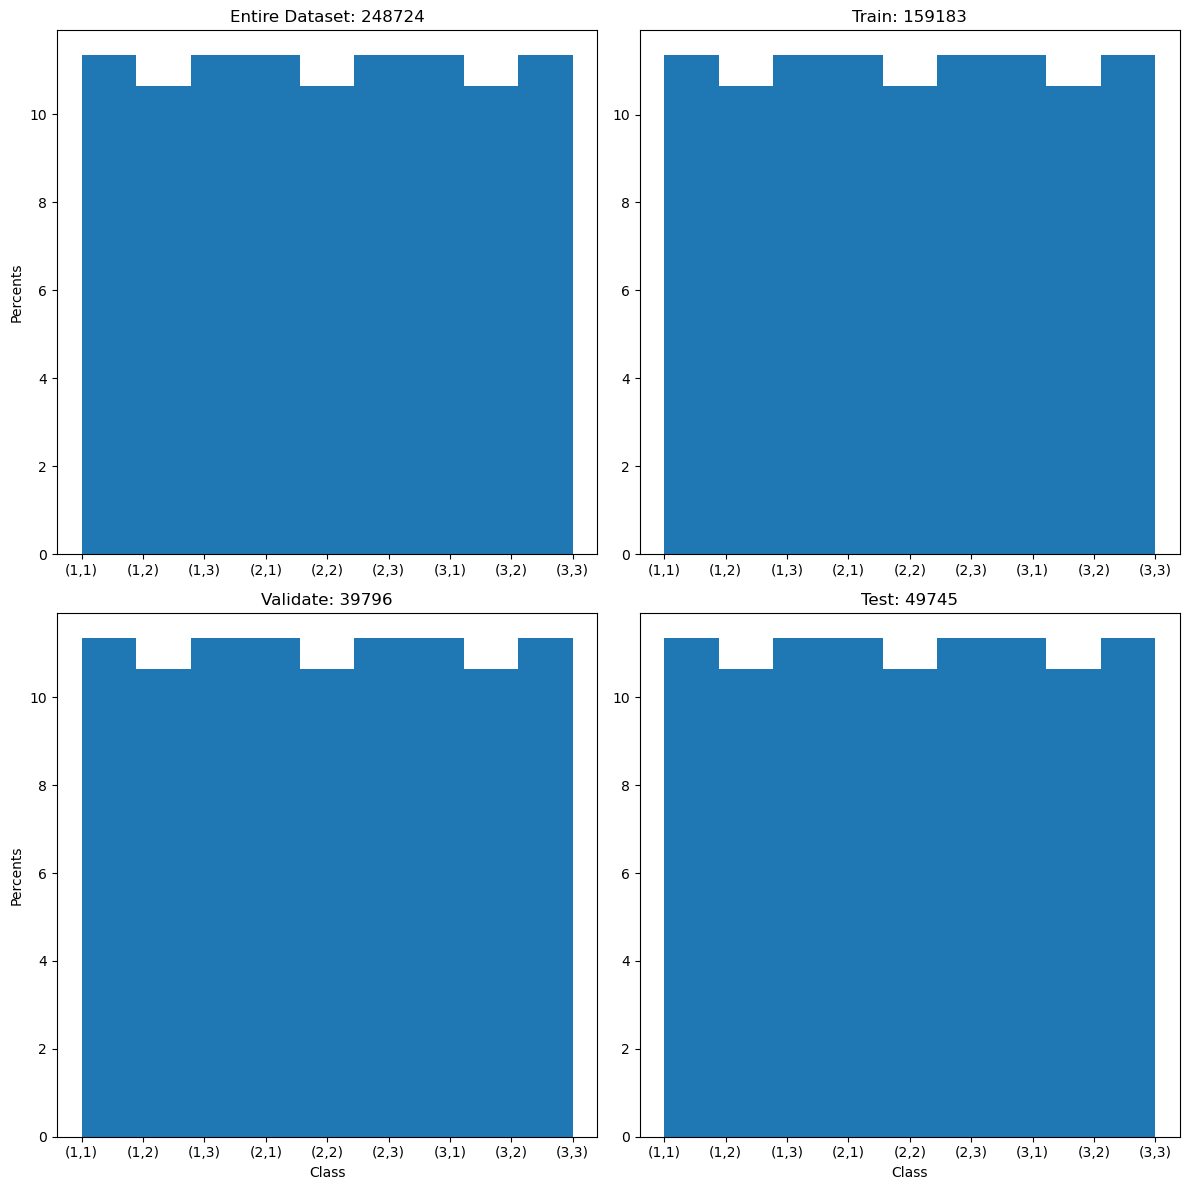

In [17]:
use_as_X = dfCorrFuncs.iloc[:,1:-1]
use_as_Y = dfCorrFuncs.iloc[:,-1]
X_trval, X_test, y_trval, y_test = train_test_split(use_as_X, use_as_Y, test_size = 0.2, stratify=use_as_Y, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(X_trval, y_trval, test_size = 0.2, stratify=y_trval, random_state=1)

cntsamples = len(use_as_Y)

show_datasets_structure_wrt_Classes(use_as_Y,"Entire Dataset", y_train,"Train", y_validate, "Validate", y_test, "Test", "Class", Classes_Labels)

In [18]:
Nodes_in = X_train.shape[1]
N_epochs=100
B_size = 64

perf_list=DoStudy(Nodes_in, cntclasses, cntsamples, N_epochs, B_size, X_train, y_train, X_validate, y_validate, X_test, y_test, CorrFuncs_prefix)

Training with 38 input nodes, 9 output nodes, 100 epochs and batch size = 64.
We use Numbers of Nodes: [450, 900].
     Training with 'sigmoid', 450 nodes, 1 layers and 450 nodes per layer completed in 0:06:00.083974
     Training with 'sigmoid', 450 nodes, 2 layers and 225_225 nodes per layer completed in 0:07:24.665216
     Training with 'sigmoid', 450 nodes, 2 layers and 270_180 nodes per layer completed in 0:07:21.270529
     Training with 'sigmoid', 450 nodes, 2 layers and 300_150 nodes per layer completed in 0:07:33.592547
     Training with 'sigmoid', 450 nodes, 3 layers and 150_150_150 nodes per layer completed in 0:08:55.297110
     Training with 'sigmoid', 450 nodes, 3 layers and 215_141_94 nodes per layer completed in 0:08:43.248894
     Training with 'sigmoid', 450 nodes, 3 layers and 258_128_64 nodes per layer completed in 0:08:40.533103
     Training with 'sigmoid', 900 nodes, 1 layers and 900 nodes per layer completed in 0:07:07.394387
     Training with 'sigmoid', 900 n

In [19]:
perf_table = results_table(perf_list)

Confusion Matrix for the best model: CorrFuncs_sigmoid_Nodes_900_Layers_3_NpL_427_284_189


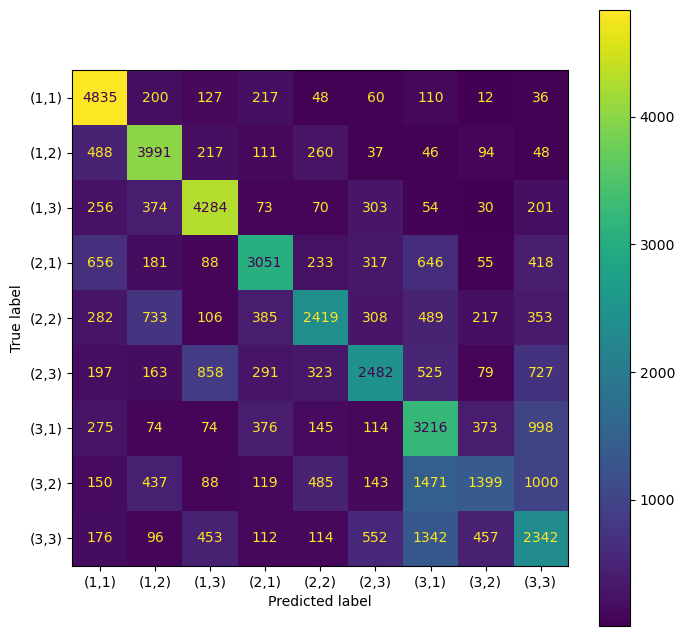

In [20]:
ConfusionMatrix(perf_table, CheckpointsPath, X_test, y_test, Classes_List, Classes_Labels, CorrFuncs_prefix)

[Back to Contents](#0)

<a id='3_2'></a>
<p style="color:#1589FF;text-align: center; font-size:150%"> <b>3.2. Time Series Raw Data Are The Input</b>

__There is NO imbalance wrt Classes in the raw Time Series data.__

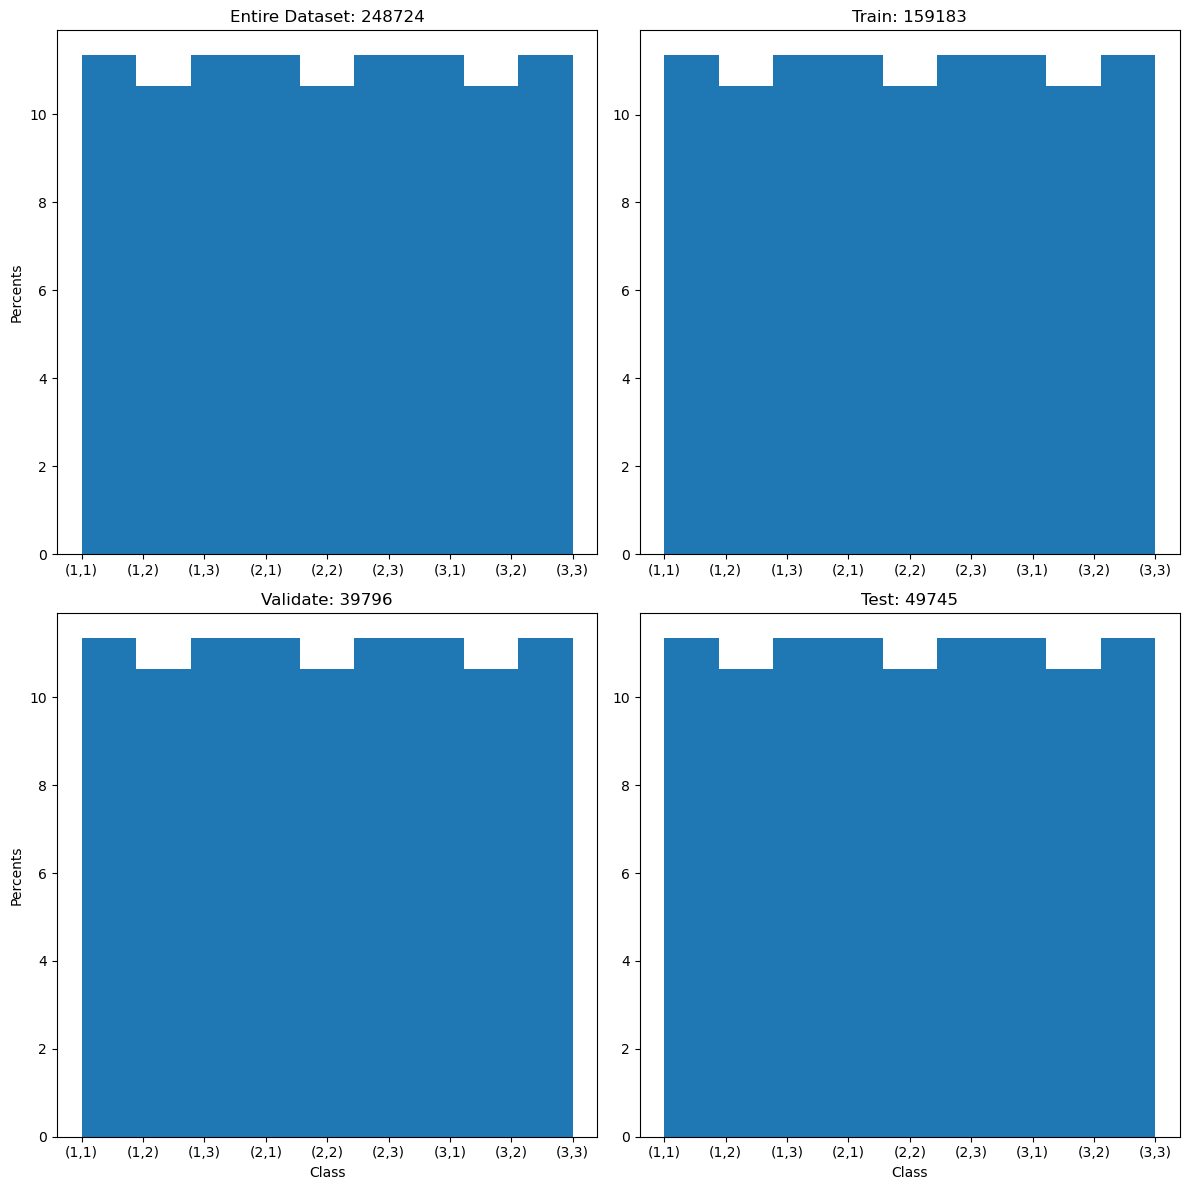

In [21]:
use_as_X = dfTimeSeries.iloc[:,1:-1]
use_as_Y = dfTimeSeries.iloc[:,-1]
X_trval, X_test, y_trval, y_test = train_test_split(use_as_X, use_as_Y, test_size = 0.2, stratify=use_as_Y, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(X_trval, y_trval, test_size = 0.2, stratify=y_trval, random_state=1)

cntsamples = len(use_as_Y)

show_datasets_structure_wrt_Classes(use_as_Y,"Entire Dataset", y_train,"Train", y_validate, "Validate", y_test, "Test", "Class", Classes_Labels)

In [22]:
Nodes_in = X_train.shape[1]
N_epochs=100
B_size = 64
perf_list=DoStudy(Nodes_in, cntclasses, cntsamples, N_epochs, B_size, X_train, y_train, X_validate, y_validate, X_test, y_test, RawData_prefix)

Training with 79 input nodes, 9 output nodes, 100 epochs and batch size = 64.
We use Numbers of Nodes: [450, 900].
     Training with 'sigmoid', 450 nodes, 1 layers and 450 nodes per layer completed in 0:10:38.256547
     Training with 'sigmoid', 450 nodes, 2 layers and 225_225 nodes per layer completed in 0:13:31.879359
     Training with 'sigmoid', 450 nodes, 2 layers and 270_180 nodes per layer completed in 0:14:17.809402
     Training with 'sigmoid', 450 nodes, 2 layers and 300_150 nodes per layer completed in 0:14:13.807589
     Training with 'sigmoid', 450 nodes, 3 layers and 150_150_150 nodes per layer completed in 0:20:22.146931
     Training with 'sigmoid', 450 nodes, 3 layers and 215_141_94 nodes per layer completed in 0:18:40.964855
     Training with 'sigmoid', 450 nodes, 3 layers and 258_128_64 nodes per layer completed in 0:19:59.193036
     Training with 'sigmoid', 900 nodes, 1 layers and 900 nodes per layer completed in 0:13:14.601550
     Training with 'sigmoid', 900 n

In [23]:
perf_table = results_table(perf_list)

Confusion Matrix for the best model: TimeSeries_sigmoid_Nodes_900_Layers_3_NpL_516_256_128


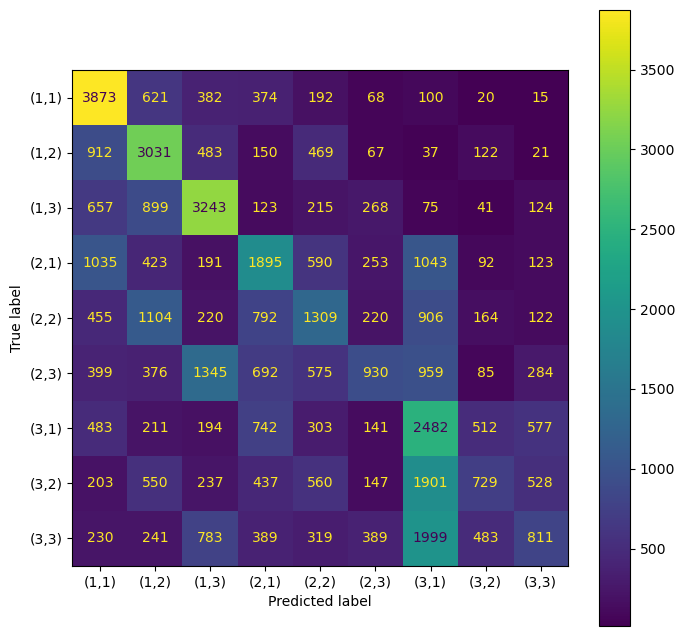

In [24]:
ConfusionMatrix(perf_table, CheckpointsPath, X_test, y_test, Classes_List, Classes_Labels, RawData_prefix)

[Back to Contents](#0)

<a id='4'></a>
<p style="padding: 8px;color:#456789; display:fill;background-color:#ADD8E6; font-size:200%"> <b>4. Conclusion</b>

__IMPORTANT :__  All below statements / observations should be read as "... _in the configurations used_".

1. Using ACF and PACF data to feed MLP shows only modest classification ability.
>
2. Using raw Time Series data to feed MLP shows very poor ability to classify.
     - ReLU fails totally
>
3. "Correlation Functions with MLP" Classifier shows __non-uniform__ performance wrt Classes:
     - class (1,1) is captured with accuracy > 85%;
     - class (3,2) is identified with accuracy 25%.
>
4. Training time with sigmoid is definitely less than one with ReLU.

__Finally,__
   - there is evidence to use MLP Classifier with ACF and PACF data to produce only _tentative_ estimates of the orders of ARMA model;
   - there is no reason to build MLP Classifier upon raw Time Series data even for this kind of estimates.

[Back to Contents](#0)